In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: rapids-21.12


In [185]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

from tqdm import tqdm 
from pathlib import Path

In [227]:
dir_github = '/media/rich/Home_Linux_partition/github_repos/'
import sys
sys.path.append(dir_github)

%load_ext autoreload
%autoreload 2
from NBAP.pipeline_2pRAM_faceRhythm.classify_ROIs import util

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import server, decomposition, classification, pickle_helpers, parallel_helpers, indexing

# %load_ext autoreload
# %autoreload 2
# from s2p_on_o2 import util
import getpass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import data

### prep sftp to get s2p outputs

In [4]:
remote_host_transfer = "transfer.rc.hms.harvard.edu"
remote_host_compute = "o2.hms.harvard.edu"
username = input('Username: ')
pw = server.pw_encode(getpass.getpass(prompt='Password: '))

Username: rh183
Password: ········


In [5]:
sftp = server.sftp_interface(hostname="transfer.rc.hms.harvard.edu", port=22)
sftp.connect(username=username, password=server.pw_decode(pw))

### download s2p outputs

In [ ]:
dir_search_s2p = '/n/data1/hms/neurobio/sabatini/rich/analysis/suite2p_output'
dir_dump = '/media/rich/Home_Linux_partition/github_repos/tmp'  ## directory to dump the stat, ops, and network files
dir_save = dir_dump

In [ ]:
paths_remote_stats = sorted(sftp.search_recursive(path=dir_search_s2p, search_pattern_re='stat\.npy', verbose=True))
paths_remote_ops = sorted(sftp.search_recursive(path=dir_search_s2p, search_pattern_re='ops\.npy', verbose=True))

In [ ]:
names_local_stats = ['__'.join(np.array(Path(path).parts)[np.array([-6,-5,-1])]) for path in paths_remote_stats]
names_local_ops = ['__'.join(np.array(Path(path).parts)[np.array([-6,-5,-1])]) for path in paths_remote_ops]

paths_local_stats = [str(Path(dir_dump) / name) for name in names_local_stats]
paths_local_ops = [str(Path(dir_dump) / name) for name in names_local_ops]

[sftp.sftp.get(path_remote, path_local) for path_remote, path_local in tqdm(zip(paths_remote_stats, paths_local_stats))];
[sftp.sftp.get(path_remote, path_local) for path_remote, path_local in tqdm(zip(paths_remote_ops, paths_local_ops))];

stats = {name: np.load(path, allow_pickle=True) for name, path in zip(names_local_stats, paths_local_stats)}
ops = {name: np.load(path, allow_pickle=True)[()] for name, path in zip(names_local_ops, paths_local_ops)}

### Import s2p outputs

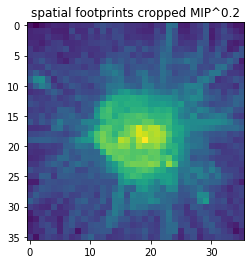

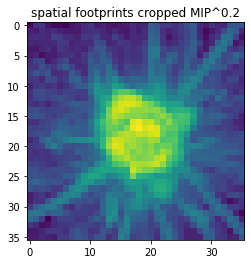

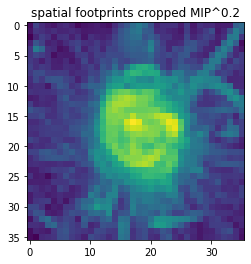

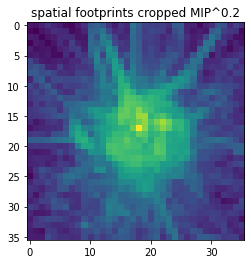

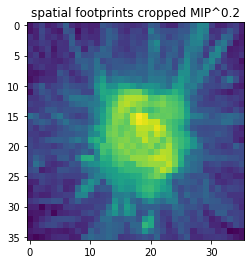

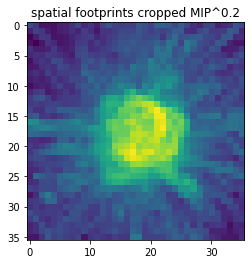

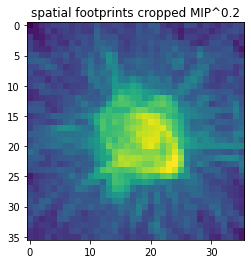

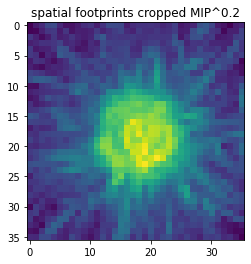

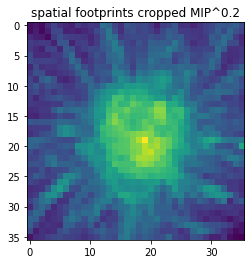

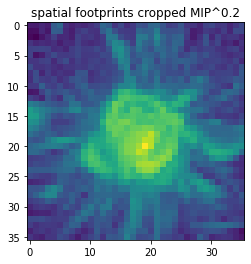

In [7]:
sf_all = util.import_multiple_stat_files(   
    paths_statFiles=paths_local_stats,
    out_height_width=[36,36],
    max_footprint_width=1441,
    plot_pref=True
)


# labels = util.import_multiple_label_files(paths_labelFiles=[item['label'] for item in paths_labelStat])
# labels_cat = np.concatenate(labels)

### Download model files

In [8]:
gdriveID_networkFiles = '1Xh02nfw_Fgb9uih1WCrsFNI-WIYXDVDn'
print(f"starting: downloading network from {gdriveID_networkFiles}")
import gdown
gdown.download_folder(id=gdriveID_networkFiles, output=dir_dump, quiet=True, use_cookies=False)
sys.path.append(dir_dump)
import model
print(f"completed: downloading network")

starting: downloading network from 1Xh02nfw_Fgb9uih1WCrsFNI-WIYXDVDn
completed: downloading network


In [9]:
import json
with open(str(Path(dir_dump) / 'params.json')) as f:
    params = json.load(f)

### Prep model

In [10]:
model = model.make_model(
    torchvision_model=params['torchvision_model'],
    n_block_toInclude=params['n_block_toInclude'],
    pre_head_fc_sizes=params['pre_head_fc_sizes'],
    post_head_fc_sizes=params['post_head_fc_sizes'],
    head_nonlinearity=params['head_nonlinearity'],
    image_shape=[3, 224, 224],
#     image_shape=[params['augmentation']['TileChannels']['n_channels']] + params['augmentation']['WarpPoints']['img_size_out']
);

In [11]:
for param in model.parameters():
    param.requires_grad = False
model.eval();

In [12]:
model.load_state_dict(torch.load(str(Path(dir_dump) / 'ConvNext_tiny__1_0_unfrozen__simCLR.pth')))

<All keys matched successfully>

---
# Preprocessing ROIs

In [13]:
sf_ptiles = np.array([np.percentile(np.sum(sf>0, axis=(1,2)), 90) for sf in tqdm(sf_all)])

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 43.77it/s]


In [14]:
scales_forRS = (250/sf_ptiles)**0.6

In [15]:
import PIL
sf_concat_rs = np.concatenate([np.stack([util.resize_affine(img, scale=scales_forRS[ii], clamp_range=True) for img in sf], axis=0) for ii, sf in enumerate(tqdm(sf_all))], axis=0)

100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.69it/s]


In [16]:
sf_cat = np.concatenate(sf_all)

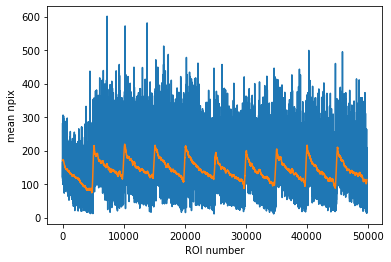

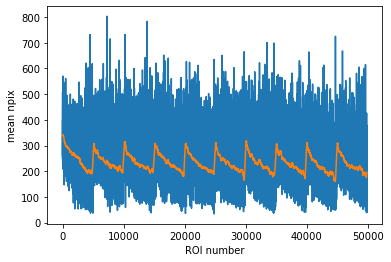

In [17]:
import scipy.signal

plt.figure()
plt.plot(np.sum(sf_cat > 0, axis=(1,2)))
plt.plot(scipy.signal.savgol_filter(np.sum(sf_cat > 0, axis=(1,2)), 501, 3))
plt.xlabel('ROI number');
plt.ylabel('mean npix');

plt.figure()
plt.plot(np.sum(sf_concat_rs > 0, axis=(1,2)))
plt.plot(scipy.signal.savgol_filter(np.sum(sf_concat_rs > 0, axis=(1,2)), 501, 3))
plt.xlabel('ROI number');
plt.ylabel('mean npix');

In [18]:
transforms_classifier = torch.nn.Sequential(
    util.ScaleDynamicRange(scaler_bounds=(0,1)),
    
    torchvision.transforms.Resize(
        size=(224, 224),
#         size=(180, 180),
#         size=(72, 72),        
        interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    
    util.TileChannels(dim=0, n_channels=3),
)

scripted_transforms_classifier = torch.jit.script(transforms_classifier)


In [19]:
dataset_labeled = util.dataset_simCLR(
        X=torch.as_tensor(sf_concat_rs, device='cpu', dtype=torch.float32),
        y=torch.as_tensor(torch.zeros(sf_concat_rs.shape[0]), device='cpu', dtype=torch.float32),
        n_transforms=1,
        class_weights=np.array([1]),
        transform=scripted_transforms_classifier,
        DEVICE='cpu',
        dtype_X=torch.float32,
    )
    
dataloader_labeled = out = torch.utils.data.DataLoader( 
        dataset_labeled,
        batch_size=1024,
        shuffle=False,
        drop_last=False,
        pin_memory=True,
        num_workers=36,
        persistent_workers=True,
#         prefetch_factor=2
)

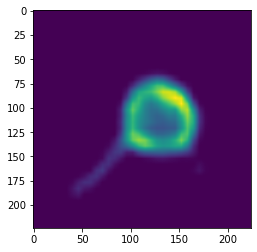

In [20]:
plt.figure()
plt.imshow(dataset_labeled[0][0][0][0])

In [21]:
[params['augmentation']['TileChannels']['n_channels']] + params['augmentation']['WarpPoints']['img_size_out']

[3, 224, 224]

In [22]:
DEVICE = 'cuda:0'

In [23]:
model = model.to(DEVICE)

In [24]:
features_nn = torch.cat([model(data[0][0].to(DEVICE)).detach() for data in tqdm(dataloader_labeled)], dim=0).cpu()

100%|███████████████████████████████████████████| 49/49 [01:05<00:00,  1.34s/it]


In [25]:
def get_balanced_sample_weights(labels):
    labels = np.int64(labels.copy())
    counts, vals = np.histogram(labels, bins=np.concatenate((np.unique(labels), [labels.max()+1])))
    vals = vals[:-1]

    n_labels = len(labels)
    weights = n_labels / counts
    
    sample_weights = np.array([weights[l] for l in labels])
    
    return sample_weights

In [26]:
from kymatio import Scattering2D

def get_latents_swt(sfs, swt, device_model):
    sfs = torch.as_tensor(np.ascontiguousarray(sfs[None,...]), device=device_model, dtype=torch.float32)
    latents_swt = swt(sfs[None,...]).squeeze()
    latents_swt = latents_swt.reshape(latents_swt.shape[0], -1)
    return latents_swt


device_model = util.set_device(use_GPU=True)

scattering = Scattering2D(J=2, L=8, shape=sf_concat_rs[0].shape[-2:])
if device_model != 'cpu':
    scattering = scattering.cuda()

latents_swt = get_latents_swt(sf_concat_rs, scattering.cuda(), device_model).cpu()

device: 'cuda:0'


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-21.12/lib/python3.8/site-packages/kymatio/frontend/entry.py:20: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  warnings.warn("Torch frontend is currently the default, but NumPy will become the default in the next"


# draw selection

In [28]:
def exclusive(set1 , set2):
    """
    finds values in set1 that are not in set2
    Args:
        set1: numpy array or list (1D)
        set2: numpy array or list (1D)
    Returns:
        vals_exclusive: a list of the values exclusive to set1
        inds_exclusive: the indices of the values that are exclusive to set1
    """
#     set1 = np.array([1,2,3])
#     set2 = np.array([2,3,4])
    xor = set(set1) ^ set(set2)
    vals_exclusive = list(set(set1).intersection(list(xor)))
    inds_exclusive = np.in1d(set1 , vals_exclusive)
    return vals_exclusive , inds_exclusive

In [29]:
n_pcs_toKeep_nn = 40
n_pcs_toKeep_swt = 10

# comp_nn, scores_nn, SVs, EVR_nn = decomposition.torch_pca(features_nn_z, rank=30, zscore=True)
comp_nn, scores_nn, SVs, EVR_nn = decomposition.torch_pca(features_nn, rank=n_pcs_toKeep_nn, zscore=False)
comp_swt, scores_swt, SVs, EVR_swt = decomposition.torch_pca(latents_swt, rank=n_pcs_toKeep_swt)
comp, scores_image, SVs, EVR_image = decomposition.torch_pca(sf_concat_rs.reshape(sf_concat_rs.shape[0], -1), rank=5)

# features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn]], dim=1)
# features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_swt]], dim=1)
# features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_image]], dim=1)
features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn, scores_swt]], dim=1)
# features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn, scores_swt, scores_image]], dim=1)

In [30]:
from umap import UMAP
umap = UMAP(
    n_neighbors=30,
    n_components=2,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)
emb_umap = umap.fit_transform(features_norm)
# emb_nn = umap.fit_transform(scores_nn)
# emb_swt = umap.fit_transform(latents_swt)

In [31]:
embedding = emb_umap

In [39]:
bool_good, dist_mat_pruned = util.get_spread_out_points(emb_umap, thresh_dist=0.2, n_iter=3)
idx_good = np.nonzero(bool_good)[0]

 98%|██████████████████████████████████▎| 48921/49814 [00:28<00:00, 1877.56it/s]/media/rich/Home_Linux_partition/github_repos/NBAP/pipeline_2pRAM_faceRhythm/classify_ROIs/util.py:557: RuntimeWarning: All-NaN slice encountered
  if np.nanmin(dist_mat_pruned[idx]) < thresh_dist:
100%|███████████████████████████████████| 49814/49814 [00:29<00:00, 1700.40it/s]
/media/rich/Home_Linux_partition/github_repos/NBAP/pipeline_2pRAM_faceRhythm/classify_ROIs/util.py:569: RuntimeWarning: All-NaN slice encountered
  if np.nanmin(dist_mat_raw[idx][idx_good]) > thresh_dist:
100%|███████████████████████████████████| 49814/49814 [00:18<00:00, 2661.39it/s]


In [316]:
import numpy as np

from matplotlib.widgets import LassoSelector
import matplotlib.path


class drawSelect_scatterplot:
    """
    Select indices from a matplotlib collection using `LassoSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).

    Parameters
    ----------
    ax : `~matplotlib.axes.Axes`
        Axes to interact with.
    collection : `matplotlib.collections.Collection` subclass
        Collection you want to select from.
    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to *alpha_other*.
    """

    def __init__(self, pts_y, pts_x, alpha_other=0.3, kwargs_scatter={}, callback=lambda x: None):
        self.pts_y = pts_y
        self.pts_x = pts_x
        
        self.ind_toInclude = np.arange(len(pts_y))
        self.alpha_other = alpha_other
        
        self.kwargs_scatter = kwargs_scatter
        
        self.callback = callback
        
    def scatter(self):
        self.fig, self.ax = plt.subplots()
        self.collection = self.ax.scatter(self.pts_y, self.pts_x, **self.kwargs_scatter)
        
        self.xys = self.collection.get_offsets()
        self.Npts = len(self.xys)
        
        self.canvas = self.ax.figure.canvas
        
        # Ensure that we have separate colors for each object
        self.fig.canvas.draw()
        self.fc = self.collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))
        
        self.lasso = LassoSelector(self.ax, onselect=self.onselect)
        self.ind = []
        
        self.callback(self.ax)
        
        return self.fig, self.ax
        
    def onselect(self, verts):
        path = matplotlib.path.Path(verts)
        self.ind = np.array(np.nonzero(path.contains_points(self.xys))[0])
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()
        self.ax.clear()
        self.ax.scatter(self.pts_y, self.pts_x, c=[0.8, 0.8, 0.8], **self.kwargs_scatter)
        self.ax.scatter(self.pts_y[self.ind], self.pts_x[self.ind], c=[0,0,0], **self.kwargs_scatter)
        fig.canvas.draw()
        self.callback(self.ax)

    def disconnect(self):
        self.lasso.disconnect_events()
        self.fc[:, -1] = 1
        self.canvas.draw_idle()

def plotMasks(selector , ax):
#     print(selector.ind)
    toInc = np.array(selector.ind_toInclude)[selector.ind]
    masks_all_selected = np.zeros((meanImg.shape[0] , meanImg.shape[1]))
#     for ii in selector.ind:
    for ii in toInc:
        masks_all_selected[stat[()][ii]['ypix'] , stat[()][ii]['xpix'] ] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])
#         masks_all_selected[stat[()][ii]['ypix'] , stat[()][ii]['xpix'] ] = stat[()][ii]['lam'] / np.max(stat[()][ii]['lam'])

    ax.imshow(masks_all_selected)

    print(f'Number of selected ROIs: {len(selector.ind)}')

In [317]:
from functools import partial

<IPython.core.display.Javascript object>


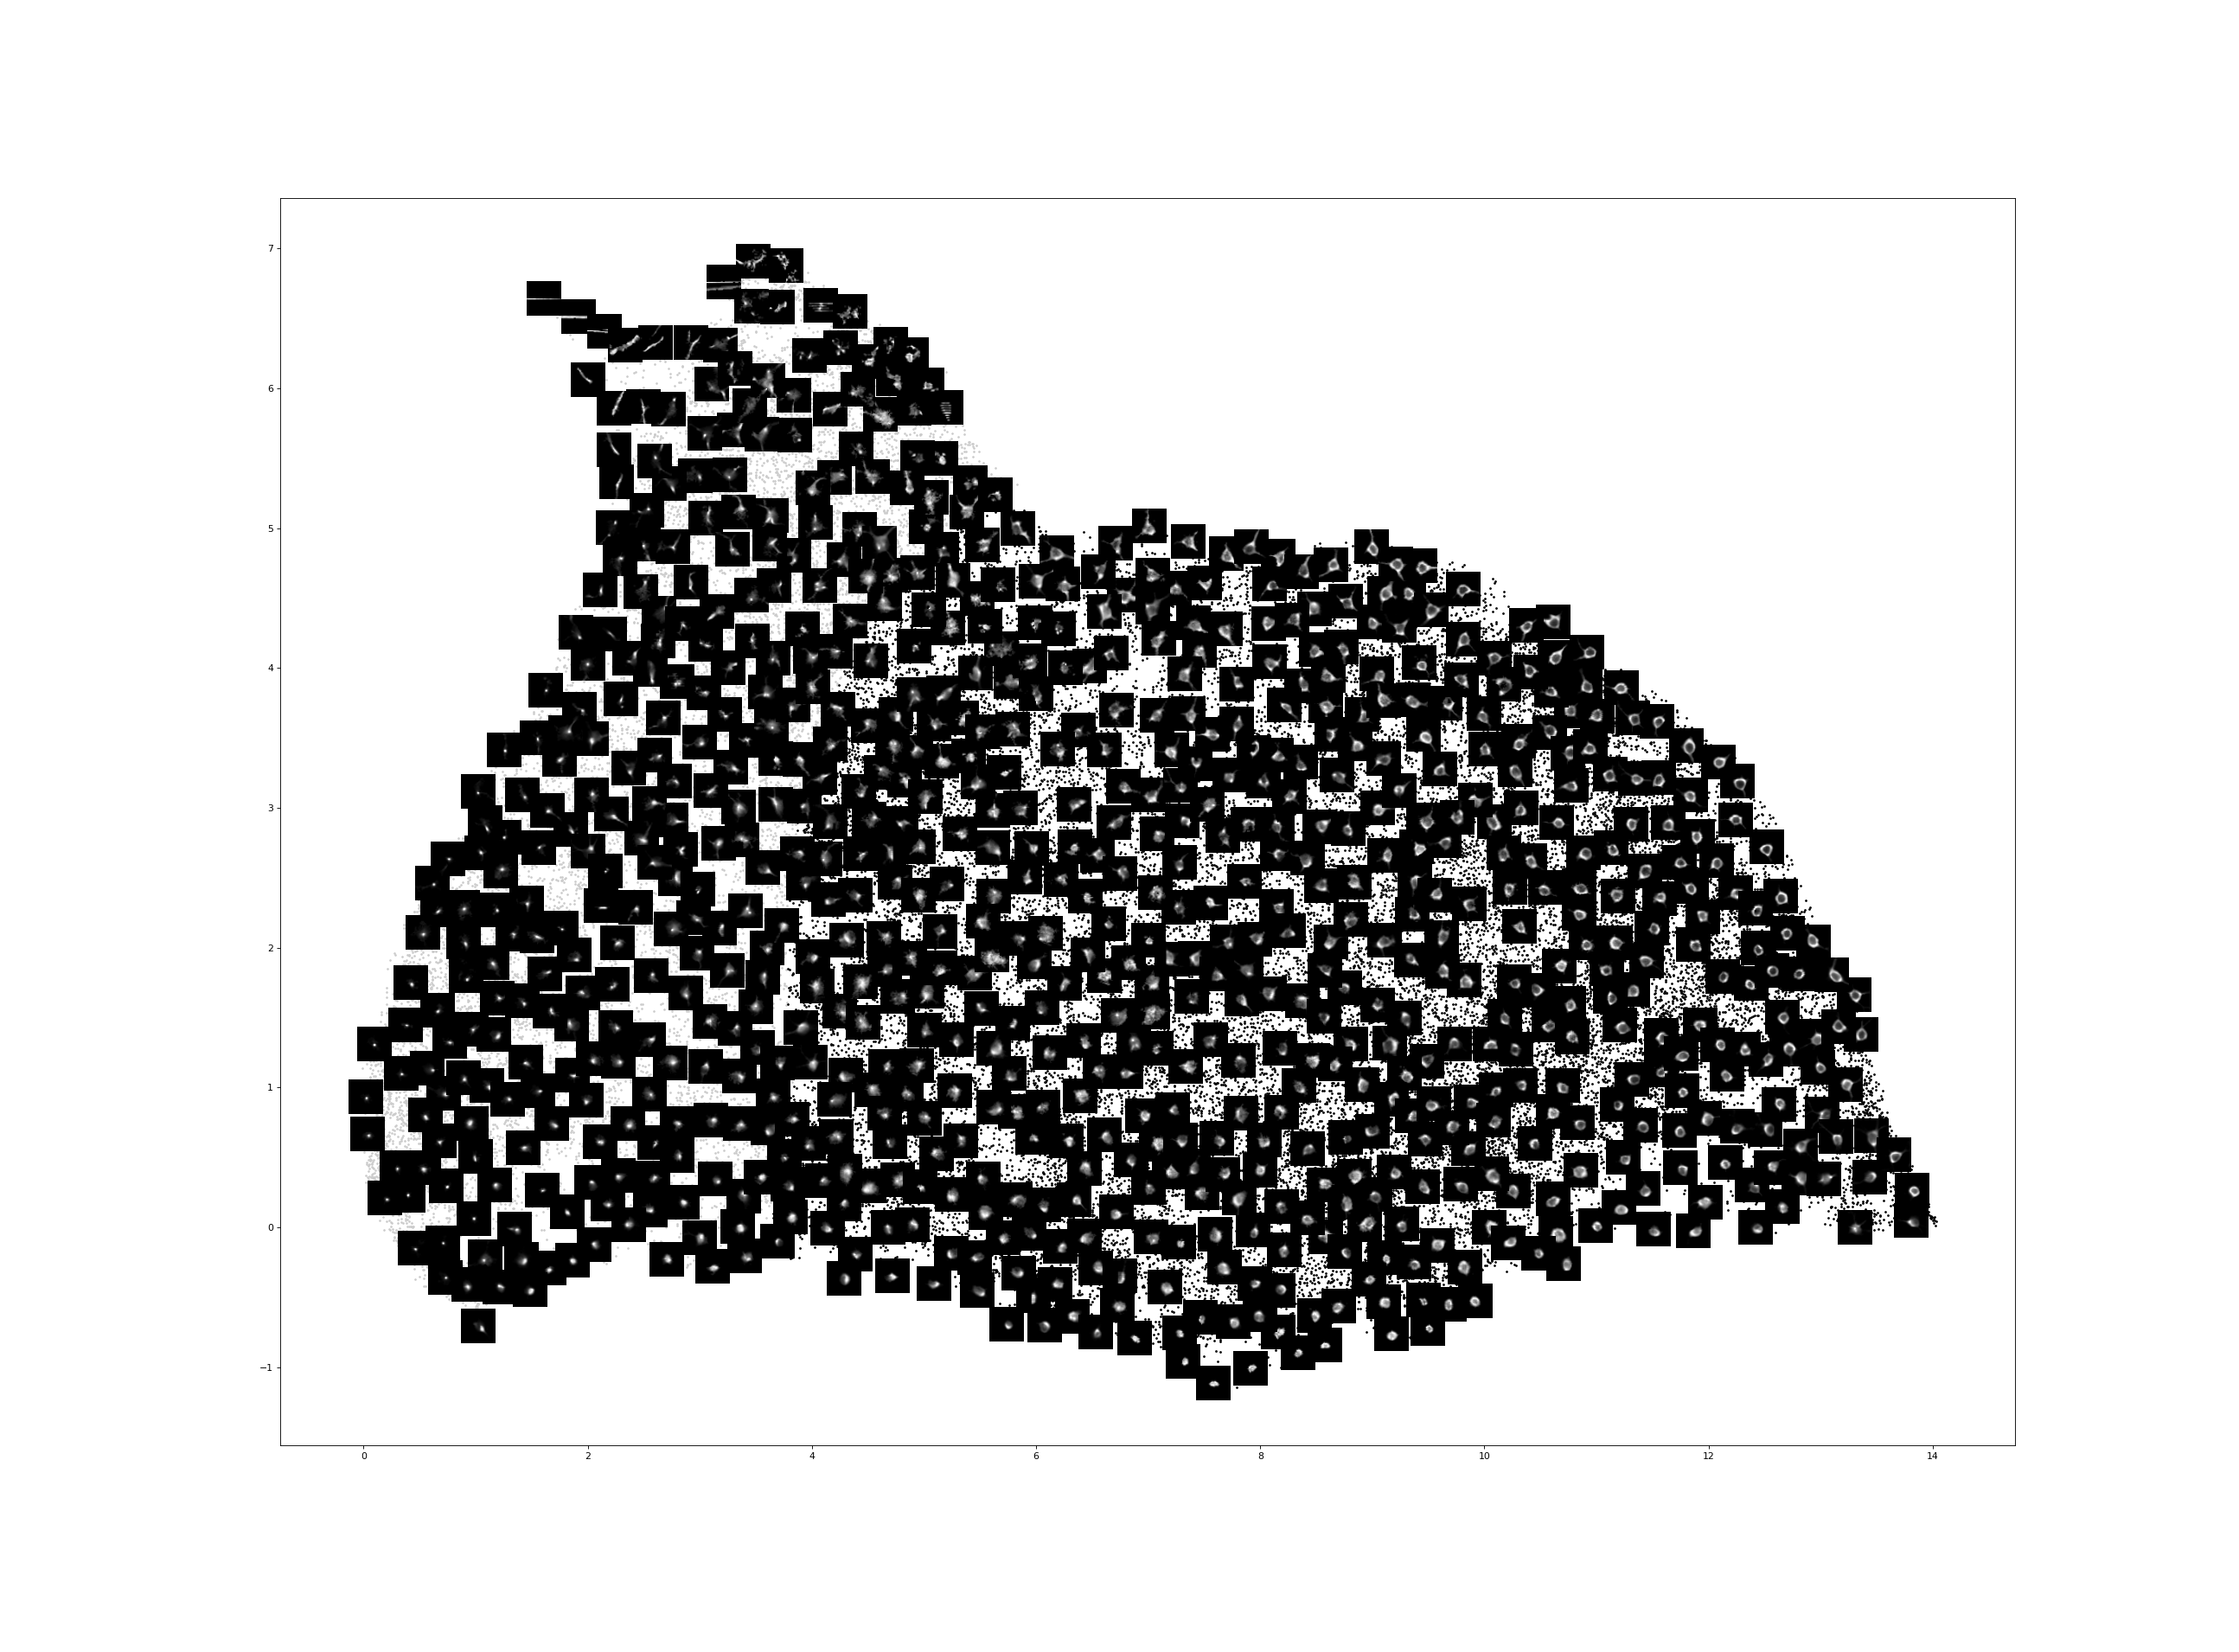

In [318]:
%matplotlib notebook

from matplotlib.offsetbox import OffsetImage, AnnotationBbox


x, y, ims_subset = emb_umap[idx_good,0], emb_umap[idx_good,1], sf_concat_rs[idx_good]
def getImage(img):
    return OffsetImage(img, cmap='gray')
def callback_overlayIms(ax, x,y,imgs):
    for x0, y0, img in zip(x, y, ims_subset):
        ab = AnnotationBbox(getImage(img), (x0, y0), frameon=False)
        ax.add_artist(ab)
        
draw = drawSelect_scatterplot(emb_umap[:,0], emb_umap[:,1], alpha_other=0.3, kwargs_scatter={'s':2}, callback=partial(callback_overlayIms, x=x, y=y, imgs=ims_subset))
fig, ax = draw.scatter()

In [237]:
n_sessions = len(sf_all)
idx_session_cat = np.concatenate([[ii]*sf_all[ii].shape[0] for ii in range(n_sessions)])
bool_good_cat = indexing.idx2bool(draw.ind, length=len(idx_session_cat))
idx_good_sessions = [np.cumsum(idx_session_cat==ii)[bool_good_cat * (idx_session_cat==ii)] for ii in range(n_sessions)]
preds_good_sessions = {np.int64((bool_good_cat * (idx_session_cat==ii))[idx_session_cat==ii]) for ii in range(n_sessions)}
# preds_sessions = [np.cumsum(idx_session_cat)[np.isin(draw.ind, np.nonzero(idx_session_cat==ii)[0])] for ii in range(n_sessions)]
# idx_good_sessions = [np.nonzero(pred)[0] for pred in preds_sessions]
# # idx_good_sessions = [np.nonzero(np.isin(draw.ind, np.nonzero(idx_session_cat==ii)[0]))[0] for ii in range(n_sessions)]


In [202]:
stats_list = [stat for (name_stat, stat) in stats.items()]
ops_list = [op for (name_op, op) in ops.items()]

In [205]:
def get_sf_sparse(stat_height_width, dtype=np.float32):
    return util.stat_to_sparse_spatial_footprints(stat=stat_height_width[0], frame_height=stat_height_width[1], frame_width=stat_height_width[2])

sf_all_sparse = parallel_helpers.multithreading(get_sf_sparse, [(stat, op['Ly'], op['Lx']) for stat,op in zip(stats_list, ops_list)], workers=20)

In [ ]:
import sparse

def make_colored_FOV(sf_sparse, stat, op, preds, path_save=None):
    sf_sparse_scaled = sf_sparse.multiply(sf_sparse.max(axis=1).power(-1.0))
    sf_sparse_scaled_rsFOV = sparse.COO(sf_sparse_scaled).reshape((len(stat), op['Ly'], op['Lx']))

    colors = util.simple_cmap(([1,0.2,0], [0,1,0]))
    n_classes = 2
    sf_sparse_scaled_rsFOV_colored = np.stack([(sf_sparse_scaled_rsFOV[preds==ii,:,:,None] * np.array(colors(ii/(n_classes-1)))[None,None,:3]).sum(0) for ii in range(n_classes)], axis=-1).sum(-1).todense()

    def reshape_mROI_to_square(image, Ly, Lx):
        Ly = (Ly//3)*3
        return np.reshape(image.T[:,:Ly], (Lx, (Ly//3), 3), order='F').transpose(1,0,2).reshape(Ly//3, Lx*3, order='F')

    sf_sparse_scaled_rsFOV_colored_square = np.stack([reshape_mROI_to_square(image, op['Ly'], op['Lx']) for image in sf_sparse_scaled_rsFOV_colored.transpose((2,0,1))], axis=-1)

    plt.figure(figsize=(40,30))
    plt.imshow(sf_sparse_scaled_rsFOV_colored_square, aspect='auto')
    
    if path_save is not None:
        plt.savefig(path_save)

paths_fig_colored_FOV = [str(Path(dir_save) / (name[:-10]+'__ColoredFOV.png')) for name,item in stats.items()]
[make_colored_FOV(sf_all_sparse[ii], stats_list[ii], ops_list[ii], preds_good_sessions[ii], paths_fig_colored_FOV[ii]) for ii in range(n_sessions)]

In [319]:
classification_output = {
    'preds': {name[:-10]: preds for name, preds in zip(names_local_stats, preds_good_sessions)},
    'sf_all_sparse': sf_all_sparse,
    'Lx_all':[op['Lx'] for op in ops_list],
    'Ly_all':[op['Ly'] for op in ops_list],
}

pickle_helpers.simple_save(classification_output, str(Path(dir_save) / 'drawn_roi_classification_output.pkl'))

In [321]:
sftp.sftp.put(str(Path(dir_save) / 'drawn_roi_classification_output.pkl'), '/n/data1/hms/neurobio/sabatini/rich/analysis/classify_rois/AEG21_and_AEG22_handDrawnClassification/drawn_roi_classification_output.pkl')

<SFTPAttributes: [ size=22867907 uid=140162 gid=3416 mode=0o100664 atime=1653796706 mtime=1653796713 ]>